# Face detection

Getting face images from videos

In [ ]:
#default_exp face_detection

In [ ]:
#export
from IPython.display import HTML
import cv2
from fastai.core import *
from fastai.vision import *
from facenet_pytorch import MTCNN
from kgl_deepfake.nb_00 import *

## Data

In [ ]:
SOURCE = Path('../data/train_sample_videos/')

In [ ]:
f = get_files(SOURCE, extensions=['.json'])[0]
annots = pd.read_json(f).T
annots.reset_index(inplace=True)
annots.rename({'index':'fname'}, axis=1, inplace=True)
annots.head()

,fname,label,split,original
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
2,abarnvbtwb.mp4,REAL,train,None
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


## Video -> Image(s)

A video consists of a sequence of images, frames.  Here's how to extract the frames using `opencv`.

In [ ]:
fn = SOURCE/annots.fname[349]
fn

PosixPath('../data/train_sample_videos/eekozbeafq.mp4')

In [ ]:
vcap = cv2.VideoCapture(str(fn))
success, frame = vcap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
vcap.release()

In [ ]:
frame.shape

(1080, 1920, 3)

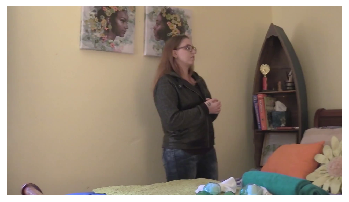

In [ ]:
plt.imshow(frame); plt.axis('off');

## Detecting faces in images

`facenet_pytorch`'s `MTCNN` can be used to detect faces in images.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

`post_process` is set to `False`, otherwise results are weird.

In [ ]:
detector = MTCNN(device=device, post_process=False)

In [ ]:
pilimg = PIL.Image.fromarray(frame)

In [ ]:
face = detector(pilimg)

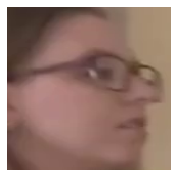

In [ ]:
Image(face.type(torch.uint8)).show(figsize=(3, 3))

By defulat, `MTCNN` returns the largest face in the images.  It can also return all the faces, as well as the probability of each face.

In [ ]:
detector = MTCNN(device=device, post_process=False, select_largest=False,
                 keep_all=True)

In [ ]:
faces, probs = detector(pilimg, return_prob=True)

In [ ]:
len(faces[0]), len(faces[1])

(3, 3)

Probabilities of the three detected faces.

In [ ]:
probs

array([0.999651, 0.99468 , 0.782902], dtype=float32)

Face 2 looks like:

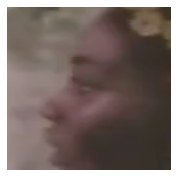

In [ ]:
Image(faces[2].type(torch.uint8)).show()

The margin around the faces can also be changed.

In [ ]:
detector = MTCNN(device=device, post_process=False, margin=70)

In [ ]:
face = detector(pilimg)

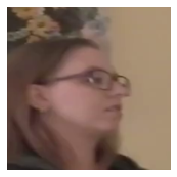

In [ ]:
Image(face.type(torch.uint8)).show()

## `DetectionPipeline`

`DetectionPipeline` is a face detection pipeline that processes a single video file at a time and returns detected faces from the video.

In [ ]:
#export
class DetectionPipeline: 
    def __init__(self, detector=None, nf=None, bs=60, fsz=None):
        if detector is None: detector = self.default_detector()
        self.detector = detector
        self.nf, self.bs, self.fsz = nf, bs, fsz
    
    def default_detector(self):
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        return MTCNN(device=device, image_size=256,
                     post_process=False, select_largest=False, keep_all=True)
        
    def get_sample(self, vlen, n_frames):
        if n_frames is None: return np.arange(0, vlen)
        else: return np.linspace(0, vlen - 1, n_frames).astype(int)
    
    def resize(self, frame, size):
        return frame.resize([int(d * size) for d in frame.size])
    
    def get_savepaths(self, filename, idxs, label=None, save_dir=None):
        if isinstance(filename, str): filename = Path(filename)
        if save_dir is None: save_dir = Path('./')
        if label is None: save_paths = [save_dir/f'{filename.stem}_{i:03d}.png' for i in idxs]
        else: save_paths = [save_dir/f'{filename.stem}_{i:03d}_{label}.png' for i in idxs]
        return [str(o) for o in save_paths]  
            
    def equalize(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        frame[:,:,0] = clahe.apply(frame[:,:,0])
        return cv2.cvtColor(frame, cv2.COLOR_YCrCb2RGB)
    
    def __call__(self, filename, equalize=False, label=None, save_dir=None):
        assert Path(filename).exists()
        vcap = cv2.VideoCapture(str(filename))
        vlen = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))
        sample = self.get_sample(vlen, self.nf)
        iframes, faces, probs = [], [], []
        ib, fb = [], []
        for i in progress_bar(range(vlen)):
            _ = vcap.grab()
            if i in sample:
                success, f = vcap.retrieve()
                if not success: continue
                if equalize: f = self.equalize(f)
                else: f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
                f = PIL.Image.fromarray(f)
                if self.fsz is not None: f = self.resize(f, self.fsz)
                ib.append(i); fb.append(f)
                if len(fb) % self.bs == 0 or i == sample[-1]:
                    savepaths = self.get_savepaths(filename, ib, label, save_dir) if save_dir else None
                    faceb, probb = self.detector(fb, return_prob=True, save_path=savepaths)
                    iframes.extend(ib); faces.extend(faceb); probs.extend(probb)
                    ib, fb = [], []
        vcap.release()
        return iframes, faces, probs

Function to plot all detected faces, if any, from multiple frames, along with the probabilities.

In [ ]:
#export
def plt_frames_faces(iframes, faces, probs):
    ncols = len(iframes)
    nrows = max(len(face) for face in faces if face is not None)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3*ncols, 3*nrows))
    if len(axs.shape) == 1: axs = axs[None,...]
    for axcol, iframe, faces_, probs_ in zip(axs.T, iframes, faces, probs):
        if faces_ is None:
            for i, ax in enumerate(axcol): 
                if i==0: ax.set_title(f'frame {iframe}')
                ax.yaxis.set_ticklabels([]); ax.yaxis.set_ticks([])
                ax.xaxis.set_ticklabels([]); ax.xaxis.set_ticks([])
            continue
            
        for i, (ax, f_, p_) in enumerate(itertools.zip_longest(axcol, faces_, probs_)):
            if p_: 
                ax.imshow(f_.permute(1, 2, 0).type(torch.uint8).numpy())
                ax.set_xlabel(f'prob = {p_:.4f}')
            if i==0: ax.set_title(f'frame {iframe}')
            ax.yaxis.set_ticklabels([]); ax.yaxis.set_ticks([])      
            ax.xaxis.set_ticklabels([]); ax.xaxis.set_ticks([])
            
    return fig, axs

In [ ]:
#export
def plt_frames_faces_vert(iframes, faces, probs):
    nrows = len(iframes)
    ncols = max(len(face) for face in faces if face is not None)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3*ncols, 3*nrows))
    if len(axs.shape) == 1: axs = axs[...,None]
    for axframe, iframe, faces_, probs_ in zip(axs, iframes, faces, probs):
        if faces_ is None:
            for i, ax in enumerate(axframe): 
                if i==0: ax.set_ylabel(f'frame {iframe}')
                ax.yaxis.set_ticklabels([]); ax.yaxis.set_ticks([])
                ax.xaxis.set_ticklabels([]); ax.xaxis.set_ticks([])
            continue
            
        for i, (ax, f_, p_) in enumerate(itertools.zip_longest(axframe, faces_, probs_)):
            if p_: 
                ax.imshow(f_.permute(1, 2, 0).type(torch.uint8).numpy())
                ax.set_xlabel(f'prob = {p_:.4f}')
            if i==0: ax.set_ylabel(f'frame {iframe}')
            ax.yaxis.set_ticklabels([]); ax.yaxis.set_ticks([])      
            ax.xaxis.set_ticklabels([]); ax.xaxis.set_ticks([])
            
    return fig, axs

In [ ]:
fn = SOURCE/annots.fname[345]
fn

PosixPath('../data/train_sample_videos/edyncaijwx.mp4')

In [ ]:
HTML(html_vid(fn))

In [ ]:
mtcnn_params = dict(device='cuda:0' if torch.cuda.is_available() else 'cpu',
                    image_size=256,
                    select_largest=False, post_process=False)
detector = MTCNN(keep_all=True, **mtcnn_params)

Detect from 15 frames (evenly spaced in time) in the video.

In [ ]:
facepipe = DetectionPipeline(nf=15)

In [ ]:
iframes, faces, probs = facepipe(fn)

In [ ]:
len(iframes), len(faces), len(probs)

(15, 15, 15)

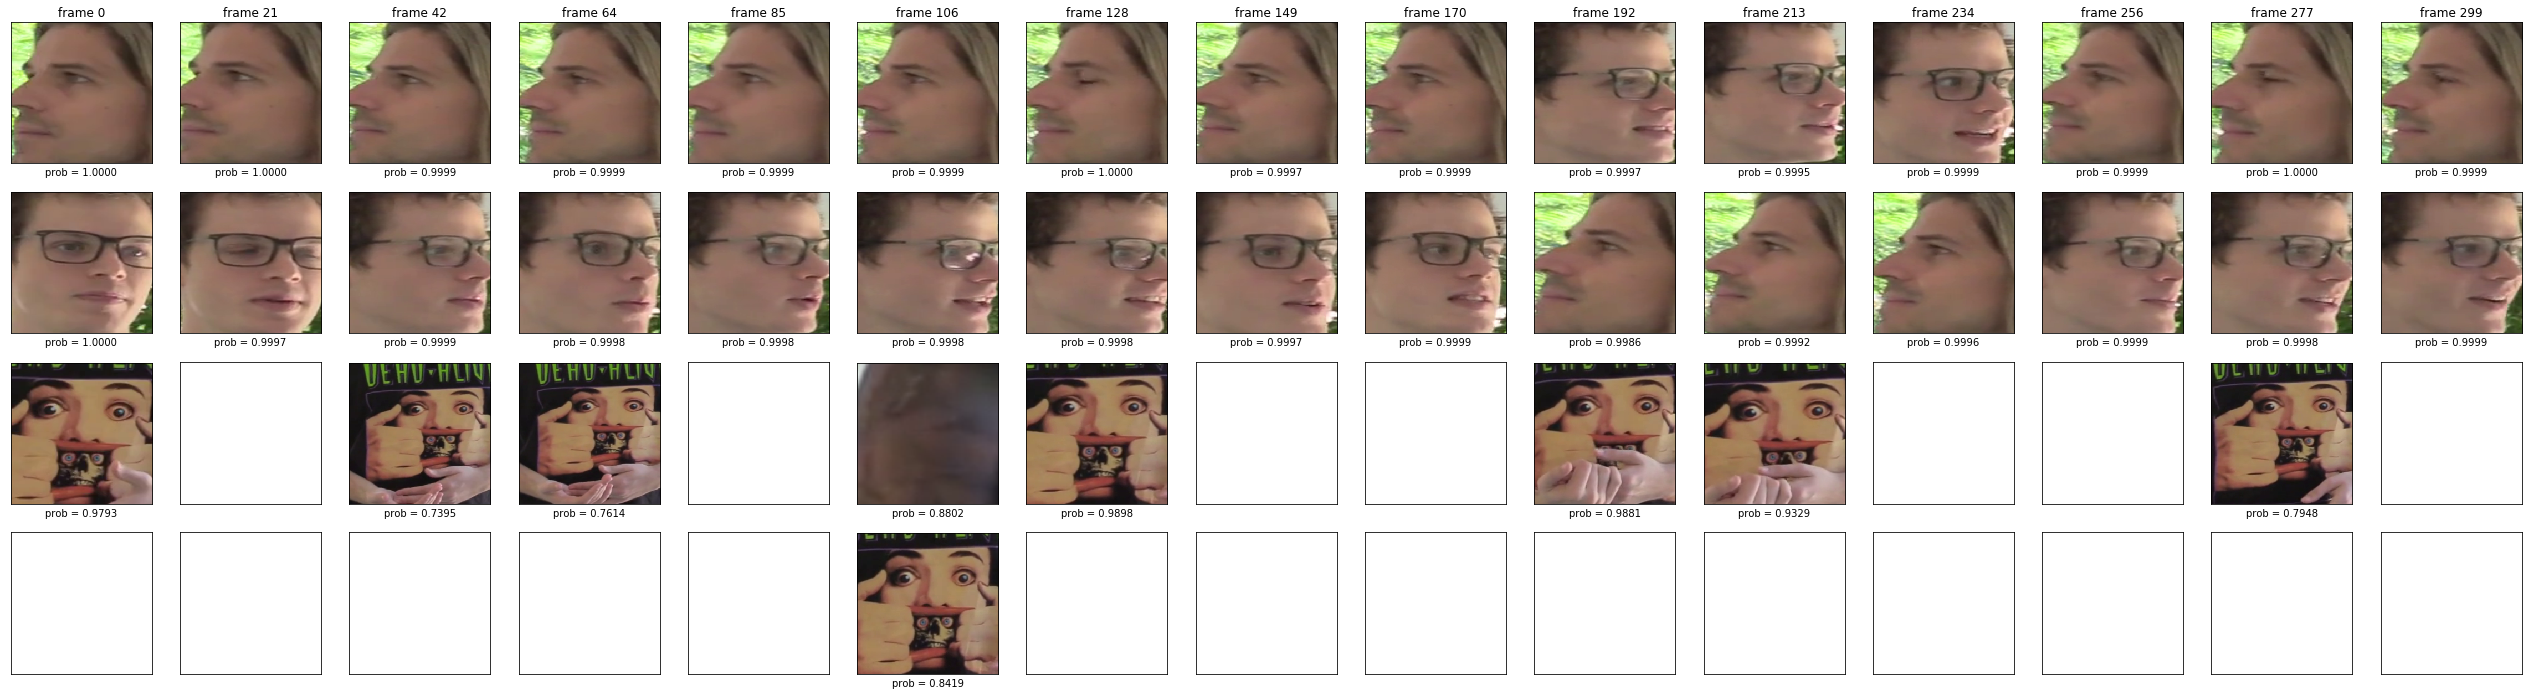

In [ ]:
fig, axs = plt_frames_faces(iframes, faces, probs)

## Getting the first detected face from a video

`get_first_face` iterates through the frames of a video, but stops the iteration once it detects a face and returns it.

In [ ]:
#export
def get_first_face(detector, fn, resize=.5, equalize=False):
    '''
    Returns the first detected face from a video
    '''
    assert Path(fn).exists()
    v_cap = cv2.VideoCapture(str(fn))
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    iframe, face = None, None
    for i in range(v_len):
        _ = v_cap.grab()
        success, frame = v_cap.retrieve()
        if not success: continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
        if equalize:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            frame[:,:,0] = clahe.apply(frame[:,:,0])
        frame = cv2.cvtColor(frame, cv2.COLOR_YCrCb2RGB)
        frame = PIL.Image.fromarray(frame)
        if resize is not None: frame = frame.resize([int(d * resize) for d in frame.size])
        face = detector(frame)
        if face is not None:
            iframe = i
            break
    v_cap.release()
    return iframe, face

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
detector = MTCNN(device=device, post_process=False, select_largest=False)

In [ ]:
iframe, face = get_first_face(detector, fn)

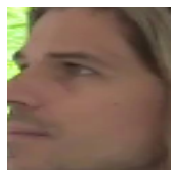

In [ ]:
Image(face.type(torch.uint8)).show()

## Cutomized `ImageList` that loads the first face detected from a video

Define a custom `ImageList` that will take paths to video files and return an image from each.  In this case, it's also necessary to add the additional arguments introduced in `__init__` to `copy_new` (https://docs.fast.ai/tutorial.itemlist.html#Keeping-__init__-arguments).

It's important to note that this class assumes that every video will return a face, otherwise everything will be very slow, fastai will warn that the data is broken, and there will most likely be an error during training.  One reliable way to ensure that every video will return a face is to set `equalize` to `True`.  This ensures that all videos will have reasonable luminosity/contrast for face detection.

In [ ]:
#export
class VideoFaceList(ImageList):
    def __init__(self, *args, detector=None, device=None, resize=.5, equalize=True, **kwargs):
        super().__init__(*args, **kwargs)
        if device is None: device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        if detector is None: detector = MTCNN(device=device, post_process=False, select_largest=False, margin=0)
        self.detector, self.resize, self.equalize = detector, resize, equalize
        self.copy_new.extend(['detector', 'resize', 'equalize'])
    
    def get_face(self, fn:Path):
        iframe, face = get_first_face(self.detector, fn, self.resize, self.equalize)
        if iframe is None or face is None: raise Exception(f'No faces detected in {fn}')
        return iframe, face
    
    def open(self, fn:Path):
        iframe, face = self.get_face(fn)
        return Image(face / 255)

In [ ]:
detector = MTCNN(device=device, margin=50, select_largest=True, post_process=False)
src = VideoFaceList.from_df(df=annots, path=SOURCE, cols='fname', detector=detector, equalize=True).split_by_rand_pct()

In [ ]:
%%time
sz, bs = 160, 32
data = (src.label_from_df('label').transform(get_transforms(), size=sz)
        .databunch(bs=bs, num_workers=0).normalize(imagenet_stats))

CPU times: user 20.4 s, sys: 2.7 s, total: 23.1 s
Wall time: 14.1 s


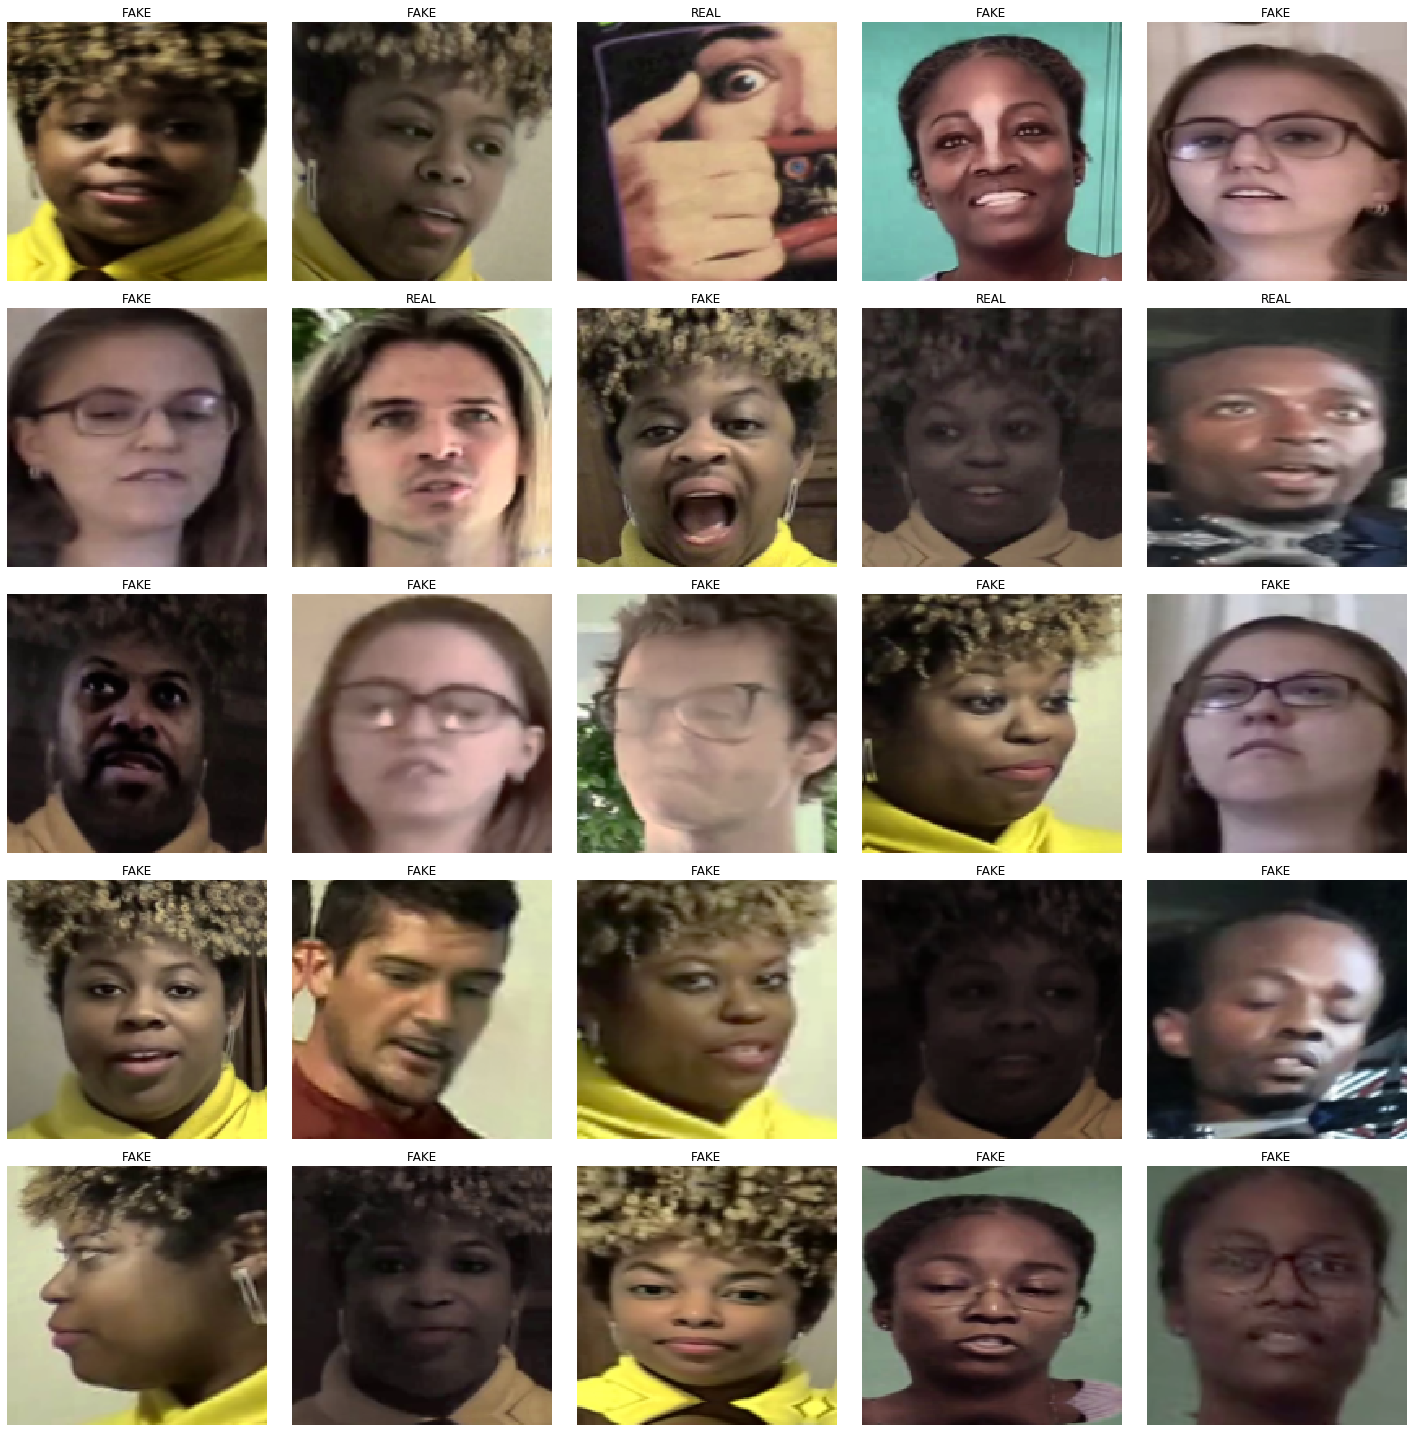

In [ ]:
data.show_batch(ds_type=DatasetType.Train)

# - fin

In [ ]:
from nbdev.export import *

In [ ]:
notebook2script()

Converted 00_data.ipynb.
Converted 01_face_detection.ipynb.
Converted 01a_faces_probs_examples-Copy1.ipynb.
Converted 01a_faces_probs_examples.ipynb.
Converted 02_fix_luminosity.ipynb.
Converted 02a_create_faceimage_dataset.ipynb.
Converted 02bis_Create_Dataset.ipynb.
Converted 02c_faces_different_dfdc_zips-Copy1.ipynb.
Converted 02c_faces_different_dfdc_zips.ipynb.
Converted 03_models.ipynb.
Converted 04_Baseline_Classification.ipynb.
Converted 04_Classification.ipynb.
Converted 04a_classification_videolist.ipynb.
Converted 05_Class_Imbalance.ipynb.
Converted 06_Focal_Loss.ipynb.
Converted 07_full_classification.ipynb.
This cell doesn't have an export destination and was ignored:
e
Converted 07a_classify_video_margin.ipynb.
Converted 07b_classify_resize.ipynb.
Converted deepfake_submission.ipynb.
Converted export_kernel_module.ipynb.
Converted test_submission.ipynb.
